In [5]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import minimize, LinearConstraint

import matplotlib as mpl

import matplotlib.pyplot as plt
plt.ion()

In [2]:
def two_link_monkey_model(t, state, P, R, tau):
    theta1, theta2, theta1_dot, theta2_dot = state
    dydt = [theta1_dot,theta2_dot,0,0]
    dydt[2] = -( P**2 * np.sin(2*theta2 - theta1) + P**2 * theta1_dot**2 * np.sin(2*theta2 - 2*theta1) 
               + (2*P**3 + 2*P*R**2) * theta2_dot**2 * np.sin(theta2 - theta1) +
               (2*P**3 - 3*P**2 + 2*P*R**2 -4*R**2) * np.sin(theta1))
    dydt[2] /= (P*P*np.cos(2*theta2 - 2*theta1) - 2*R**4 + 
                (-4*P**2 -4 +4*P)*R**2 - 2*P**4 +4*P**3 -3*P**2)
    
    dydt[3] = (P**2 * theta2_dot**2 * np.sin(2*theta2 - 2*theta1) 
               + (2*P**3 - 4*P**2 +4*P + 2*R*R*P) * theta1_dot**2 * np.sin(theta2 - theta1) +
               (2*P - P*P)*np.sin(theta2 - 2*theta1) +
               (2*P**3 - 3*P**2 + 2*P + 2*R*R*P) * np.sin(theta2))
    dydt[3] /= (P*P*np.cos(2*theta2 - 2*theta1) - 2*R**4 + 
                (-4*P**2 -4 +4*P)*R**2 - 2*P**4 +4*P**3 -3*P**2)
    
    dydt[2] *= tau
    dydt[3] *= tau
    return dydt

Text(0.5, 0, 'time')

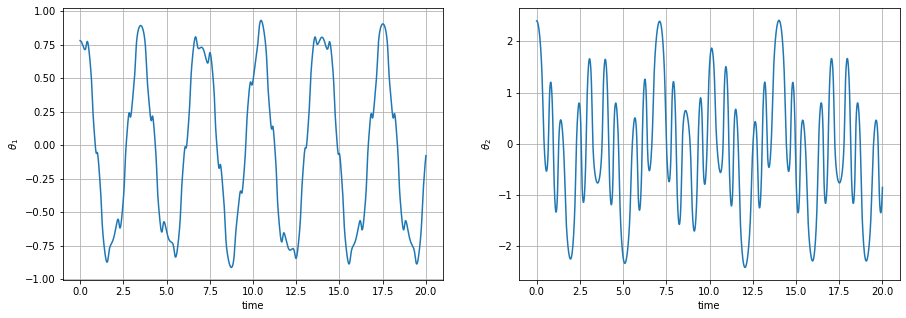

In [4]:
p = 0.06376
l = 0.61
I = 5.386 * 1e-2
g = 9.8
m = 3.083

P = p/l
R = np.sqrt(I/m*l*l)
tau = np.sqrt(g/l)

# Initial condition
dt = 0.001
t = 20
time = np.linspace(0,t,int(t/dt)) 
# initial = [0,0,1.55,11.73]
initial = [0.78,2.4,0,0]
sol = solve_ivp(lambda t, y: two_link_monkey_model(t, y, P, R, tau), 
                [0,t], initial,
                t_eval = time, 
                rtol=1e-8, atol = 1e-8)
np.save('theta1.npy', sol.y[0,:])
np.save('theta2.npy', sol.y[1,:])

plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.grid()
plt.plot(sol.t, sol.y[0,:]) 
plt.ylabel('$\\theta_1$') 
plt.xlabel('time')
plt.subplot(1,2,2)
plt.grid()
plt.plot(sol.t, sol.y[1,:]) 
plt.ylabel('$\\theta_2$') 
plt.xlabel('time')

In [7]:
# TODO : find theta1_dot, theta2_dot over min t. bang bang ?
p = 0.06376
l = 0.61
I = 5.386 * 1e-2
g = 9.8
m = 3.083

P = p/l
R = np.sqrt(I/m*l*l)
tau = np.sqrt(g/l)

def two_link_monkey_model_torque(t, state, u):
    theta1, theta2, theta1_dot, theta2_dot = state
    dydt = [theta1_dot,theta2_dot,0,0]
    dydt[2] = -( P**2 * np.sin(2*theta2 - theta1) + P**2 * theta1_dot**2 * np.sin(2*theta2 - 2*theta1) 
               + (2*P**3 + 2*P*R**2) * theta2_dot**2 * np.sin(theta2 - theta1) +
               (2*P**3 - 3*P**2 + 2*P*R**2 -4*R**2) * np.sin(theta1))
    dydt[2] /= (P*P*np.cos(2*theta2 - 2*theta1) - 2*R**4 + 
                (-4*P**2 -4 +4*P)*R**2 - 2*P**4 +4*P**3 -3*P**2)
    
    dydt[3] = (P**2 * theta2_dot**2 * np.sin(2*theta2 - 2*theta1) 
               + (2*P**3 - 4*P**2 +4*P + 2*R*R*P) * theta1_dot**2 * np.sin(theta2 - theta1) +
               (2*P - P*P)*np.sin(theta2 - 2*theta1) +
               (2*P**3 - 3*P**2 + 2*P + 2*R*R*P) * np.sin(theta2))
    dydt[3] /= (P*P*np.cos(2*theta2 - 2*theta1) - 2*R**4 + 
                (-4*P**2 -4 +4*P)*R**2 - 2*P**4 +4*P**3 -3*P**2)
    
    dydt[2] *= np.sqrt(g/l)
    dydt[2] += u[0] / (m*l*l/12)
    dydt[3] *= np.sqrt(g/l)
    dydt[3] += u[1] / (m*l*l/12)
    return dydt

# vec =[𝑡𝐹,𝑢11,..,u1N,u21,..,𝑢2𝑁,𝑞11,...,𝑞1𝑁,𝑞21,...,𝑞2𝑁,𝑞˙11,...𝑞˙2,1,...,𝑞˙2]
def cost(vec):
    length = vec.shape[0]
    N = int((length - 1)/6)
    t_f = vec[0]
    u = vec[1:2*N+1]
    t = np.linspace(0, 1, N)*t_f
    h = t[1] - t[0]
    return np.sum(u**2)*(h)


initial_angle = [0.78,2.4]
final_angle = [-0.78,-2.4]

######## Initial conditions
def start_q1(vec):
    length = vec.shape[0]
    N = int((length - 1)/6) # number of time intervals
    q1_0 = vec[2*N + 1] - initial_angle[0]
    return q1_0

def start_q2(vec):
    length = vec.shape[0]
    N = int((length - 1)/6) # number of time intervals
    q2_0 = vec[3*N + 1] - initial_angle[1]
    return q2_0

######## Final conditions
def end_q1(vec):
    length = vec.shape[0]
    N = int((length - 1)/6) # number of time intervals
    q1_f = vec[3*N] - final_angle[0]
    return q1_f

def end_q2(vec):
    length = vec.shape[0]
    N = int((length - 1)/6) # number of time intervals
    q2_f = vec[4*N] - final_angle[1]
    return q2_f

def end_time(vec):
    length = vec.shape[0]
    return vec[0] - 3
    
def dynamics_constraint_two_link(vec):
    length = vec.shape[0]
    N = int((length - 1)/6) # number of time intervals
    
    # Unpack all the variables
    t_f = vec[0]
    x = vec[2*N+1:]
    u = vec[1:2*N+1]
    u = np.reshape(u, (2,N))
    x = np.reshape(x, (4,N))
    
    # make your time vector
    t = np.linspace(0, 1, N)*t_f
    h = t[1] - t[0]
    t_c = np.linspace(t[0] + h/2, t[-1] - h/2, N - 1)
    
    x_dot = np.array(two_link_monkey_model_torque(t, x, u))
    
    # right states and left dynamics states    
    x_dot_left = x_dot[:, 0:-1]
    x_dot_right = x_dot[:, 1:]
    
    # right states and left states
    x_left = x[:, 0:-1]
    x_right = x[:, 1:]
    
    # right controls and left controls    
    u_left = u[:,0:-1]
    u_right = u[:,1:]    
    
    # center controls and states
    x_center = (1/2)*(x_left + x_right) + (h/8)*(x_dot_left - x_dot_right)
    u_center = (u_left + u_right)/2
    
    # evaluate the dynamics at the center (collocation) point
    x_dot_center = np.array(two_link_monkey_model_torque(t_c, x_center, u_center))
    
    delta = (x_left - x_right) + (h/6)*(x_dot_left + 4*x_dot_center + x_dot_right)
    delta = np.reshape(delta, 4*(N-1))
    
    return delta

In [11]:
N = 40
vec_init = np.random.rand(1 + 2*N + N*4)   #np.zeros(1 + N + N*4) #np.random.rand(1 + N + N*4) 
vec_init[2*N + 1] = initial_angle[0]
vec_init[3*N + 1] = initial_angle[1]

u_max = 20
vec_init[0] = 3
# Build bounds vector
time_bounds = [(0, None)]
control_bounds_1 = [(0, u_max) for r in range(N)]
control_bounds_2 = [(0, u_max) for r in range(N)]
q1_bounds = [(-3.14,3.14) for r in range(N)]
q2_bounds = [(-3.14,3.14) for r in range(N)]
q1_dot_bounds = [(None, None) for r in range(N)]
q2_dot_bounds = [(None, None) for r in range(N)]
    
bnds = time_bounds + control_bounds_1 + control_bounds_2 + q1_bounds + q2_bounds + q1_dot_bounds + q2_dot_bounds

res =   minimize(cost, vec_init, method="SLSQP",    # SLSQP  trust-constr 
                 bounds = bnds,
                 constraints= ({"type": "eq", "fun": lambda var: end_time(var)},
                               {"type": "eq", "fun": lambda var: start_q1(var)}, 
                               {"type": "eq", "fun": lambda var: start_q2(var)}, 
                               {"type": "eq", "fun": lambda var: end_q1(var)}, 
                               {"type": "eq", "fun": lambda var: end_q2(var)}, 
                               {"type": "eq", "fun": lambda var: dynamics_constraint_two_link(var)}))

[ 0.78        0.80357132  0.82337624  0.8346952   0.83637026  0.83128114
  0.82733847  0.83542484  0.8711314   0.98310495  1.15037045  1.23881255
  1.30681352  1.35882435  1.39062822  1.39780101  1.37737118  1.32246293
  1.20679751  1.06372833  0.9411889   0.82166073  0.75964213  0.68148266
  0.51573189  0.26930797  0.04703589 -0.09891847 -0.18446255 -0.35573548
 -0.57837413 -0.76392012 -0.87995043 -0.94248857 -0.92226904 -0.8882866
 -0.87684013 -0.86166561 -0.83125826 -0.78      ]
[ 2.4         2.67331912  2.85492367  2.94613469  2.94504323  2.85287359
  2.67592043  2.41799381  2.04819241  1.29426971  0.28984865 -0.03808806
 -0.14905107 -0.13124178 -0.03609033  0.10147756  0.2796802   0.55389412
  1.14065019  1.76101095  1.90447828  1.62071258  0.75610658 -0.09216894
 -0.2225944   0.59536319  0.94707327  0.24582711 -0.87728765 -1.14509572
 -0.43922403  0.14329442  0.08278103 -0.32021496 -1.06205526 -1.71227318
 -2.07798996 -2.30592277 -2.42197666 -2.4       ]


Text(0, 0.5, 'Torque')

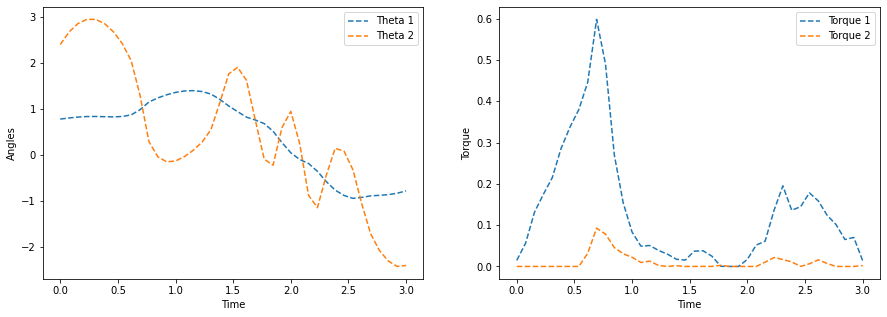

In [94]:
vec = res.x
length = vec.shape[0]
N = int((length - 1)/6) # number of time intervals
# Unpack all the variables
t_f = vec[0]
x = vec[2*N+1:]
u = vec[1:2*N+1]
u = np.reshape(u, (2,N))
x = np.reshape(x, (4,N))

np.save('theta1.npy', x[0,:])
np.save('theta2.npy', x[1,:])
print(x[0,:])
print(x[1,:])
t = np.linspace(0, 1, N)*t_f
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.plot(t, x[0,:], '--', label='Theta 1')
plt.plot(t, x[1,:], '--', label='Theta 2')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Angles')

plt.subplot(1,2,2)
plt.plot(t, abs(u[0,:]), '--', label='Torque 1')
plt.plot(t, abs(u[1,:]), '--', label='Torque 2')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Torque')
